In [294]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader

from torch.optim import SGD, Adam

from tqdm import tqdm

The data generating process works as follows (story just for reference):
Revenue ($y_i$) depends on some characteristics $X_i$ of the customer i. Customers are given a coupon (treatment $g_i$) with 50% probability . Customer who receive a coupon will spend more or less money (treatment effect $\tau_i$) depending linearly on their characteristics.

$$y_i = X_i ^\top \beta_X + g \cdot X_i ^\top \beta_{\tau}$$


In [321]:
def generate_experiment(n_obs,n_var, tau=None):
    X = np.random.multivariate_normal(
             np.zeros(n_var),
             np.eye(n_var),
             n_obs
             )
    
    
    beta = np.random.normal(scale=1, size=n_var)
    beta_X2 = np.random.normal(scale=1, size=n_var)
    beta_tau = np.random.normal(scale=0.1, size=n_var)
    
    g = np.hstack([np.ones(n_obs//2), np.zeros(n_obs//2)])
        #np.random.binomial(1,0.5,size=n_obs)
        
    if tau is None:
        tau = np.dot(X,beta_tau) #+ np.random.normal(scale=0.01, size=n_obs)
        
    y = np.dot(X,beta)  + tau*g            + np.random.normal(scale=0.1, size=n_obs)
    #y = np.dot(X,beta) + np.dot(np.power(X,2),beta_X2) + tau*g + np.random.normal(scale=0.1, size=n_obs)
    
    return X, y, g, tau, beta, beta_X2, beta_tau
    
    

In [322]:
class ExperimentData(Dataset):
    def __init__(self, X, y, g):
        self.X = X
        self.y = y
        self.g = g
        
    def __len__(self):
        return X.shape[0]
    
    def __getitem__(self, idx):
        return X[idx,:], y[idx], g[idx]
                

The model is a standard multi-layer perceptron. Classification only requires a change to the output activation from None to sigmoid.

In [324]:
class nnet(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes):
        super(nnet, self).__init__()
        
        self.input_dim = input_dim
        self.layer_sizes = hidden_layer_sizes
        self.iter = 0
        
        hidden_layer_sizes = hidden_layer_sizes + [1] # Output layer
        first_layer = nn.Linear(input_dim, hidden_layer_sizes[0])
        self.layers = nn.ModuleList(
            [first_layer] +\
            [nn.Linear(input_, output_)
             for input_, output_ in 
             zip(hidden_layer_sizes, hidden_layer_sizes[1:])])

        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        
        return x
    
    def train(self, data_loader, epochs):
        for epoch in range(epochs):
            loss = self._train_iteration(data_loader)
            if epoch % 5 == 0:
                print(f"loss: {loss}")
                
    def _train_iteration(self,data_loader):
        for i, (X,y,g) in enumerate(data_loader):
            
            X = X.float()
            y = y.unsqueeze(1).float()
            
            X = Variable(X, requires_grad=True)
            y = Variable(y, requires_grad=True)
                      
            pred = self(X)
            loss = ((y - pred)**2).mean()
            
            optim.zero_grad()
            loss.backward()
            optim.step()
               
        return loss.detach().numpy()

## Mini-batch ATE causal net
The two-model approach estimates two distinct models on the response variable, one for each group. The difference between the two estimates for the same observations is the treatment effect for a single observation. Disjoint estimation may result in models that are not well calibrated.

Solution: Train a neural network to estimate the treatment effect directly. This is not possible for a single observation (->fundamental problem of causal inference):

$$ r_i = \hat{\tau}_i - \tau_i, $$
where $\tau_i$ is of course unknown. 

We can however evaluate the total error for groups of observations $i \in 1,\ldots,N$:

$$ \sum^N r_i = \sum^N \hat{\tau}_i - \tau_i = \sum^N \hat{\tau}_i - \sum^N \tau_i$$


The sum treatment effect is only weakly informative for the treatment effect of a single observation and estimating the overall sum of treatment effects leaves too many degrees of freedom for the treatment effect of each observations. By using mini-batches instead, the summed individual treatment effects need to be correct not only for the population N, but also for each subset of the population $M \in N$.

In [325]:
class causalnet1(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes):
        super().__init__()
        self.net = nnet(input_dim, hidden_layer_sizes)
        self.loss = []
        self.val_loss = []
        
    def forward(self, X):
        treatment_effect = self.net(X)
        return treatment_effect
    
    def train(self, data_loader, epochs, validation_data=None):
        for epoch in range(epochs):
            ATE, ATE_hat, loss, g_ratio = self._train_iteration(data_loader)
            self.loss.append(loss)
            if epoch % 5 == 0:
                if validation_data is not None:
                    tau_hat = self.net(validation_data['X'])
                    val_loss = (validation_data['tau'] - tau_hat).pow(2).mean().detach().numpy()
                    self.val_loss.append(val_loss)
                    print(f"val_loss: {val_loss}, ATE: {ATE}, ATE_hat: {ATE_hat}, loss: {loss}, balance: {g_ratio}")
                else:
                    print(f"ATE: {ATE}, ATE_hat: {ATE_hat}, loss: {loss}, balance: {g_ratio}")
            
    
    def _train_iteration(self,data_loader):
        for i, (X,y,g) in enumerate(data_loader):
            
            X = X.float()
            y = y.unsqueeze(1).float()
            
            X0 = Variable(X[g==0,:])
            y0 = Variable(y[g==0])
            
            X1 = Variable(X[g==1,:])
            y1 = Variable(y[g==1])
            
            g_ratio = g.float().mean()
            
#             response0 = self.net0(X0)
#             loss0 = ((y0 - response0)**2).mean()
            
#             response1 = self.net1(X1)
#             loss1 = ((y1 - response1)**2).mean()

            treatment_effect = self.net(X)
            
            ATE_hat = treatment_effect.mean()
            ATE     = y1.mean() - y0.mean()
            loss_treatment = (ATE - ATE_hat)**2            
            
            
#             if i % 2==0:
#                 self.net0.zero_grad()
#                 loss =  0*loss0 + loss_treatment
#                 loss.backward()
#                 optim0.step()
#             else:
            self.net.zero_grad()
            loss =  loss_treatment
            loss.backward()
            optim.step()
                
            
        return ATE.detach().numpy(), ATE_hat.detach().numpy(), loss.detach().numpy(), g_ratio
            

## Addditive two-model approach / residual network
Again estimate two networks jointly. Decompose the response estimate for treated observations into the response without treatment and the treatment effect. 

$$ \hat{y}_t = f_R(X_t) + f_T(X_t) \\
   \hat{y}_t = f_R(X_c)$$

One network $f_R$ predicts the response without treatment for each customer (treatment and control), the second network $f_T$ estimates the treatment effect. The loss for the first network is the response prediction MSE over all observations $$\frac{1}{N}\sum([\hat{y_t};\hat{y_c}] - [y_t;y_c])^2$$ the loss for the second network is the response prediction MSE for *only the treated group*, i.e. $$\frac{1}{N_T}\sum(\hat{y_t} - y_t)^2$$

This seems related to an approach called *covariate transformation* in the uplift literature. For covariate transformation, we estimate the outcome $y_i$ on a set of variables $[X_i, t_i \cdot X_i]$, where $t_i \cdot X_i$ is the interaction between the treatment indicator $t_i \in {0;1}$ and observed variables $X$. 

For the linear regression model, this is equivalent to including each variable-treatment interaction term. 

In [299]:
class causalnet2(nn.Module):
    def __init__(self, input_dim, hidden_layer_sizes):
        super().__init__()
        self.net0 = nnet(input_dim, hidden_layer_sizes)
        self.net1 = nnet(input_dim, hidden_layer_sizes)
        self.loss = []
        
    def forward(self, X):
        return self.net1(X)
    
    def train(self, data_loader, epochs):
        for epoch in range(epochs):
            ATE_diff, response_loss, g_ratio = self._train_iteration(data_loader)
            self.loss.append(response_loss)
            if epoch % 5 == 0:
                print(f"ATE Difference: {ATE_diff}, Response MSE: {response_loss}, balance: {g_ratio}")
            
    
    def _train_iteration(self,data_loader):
        for i, (X,y,g) in enumerate(data_loader):
            
            X = X.float()
            y = y.unsqueeze(1).float()
            
            X0 = Variable(X[g==0,:])
            y0 = Variable(y[g==0])
            
            X1 = Variable(X[g==1,:])
            y1 = Variable(y[g==1])
            
            g_ratio = g.float().mean()
            
            response0 = self.net0(X0)
            loss0 = ((y0 - response0).pow(2)).mean()
            
            response1 = self.net0(X1) + self.net1(X1)
            loss1 = ((y1 - response1).pow(2)).mean()
            
            ATE_hat = response1.mean() - response0.mean()
            ATE     = y1.mean() - y0.mean()
            loss_treatment = (ATE - ATE_hat).pow(2)            
            
            self.net0.zero_grad()
            loss0.backward()
            optim0.step()

            if i > 10:
                self.net1.zero_grad()
                loss1.backward()
                optim1.step()
                
            
        return ATE.detach().numpy()-ATE_hat.detach().numpy(), loss0.detach().numpy(), g_ratio
            

## Simulation

In [326]:
X, y, g, tau, coef, coef_x2, coef_tau = generate_experiment(15000,10, tau=None)

For evaluation in the simulation context, I assume that the treatment effects are known and calculate the accuracy on the model in estimating the treatment effects on a holdout validation set. In practice, the true treatment effects are unknown, of course, so holdout evaluation is an open question.

In [329]:
from sklearn.model_selection import train_test_split
X, X_val, y, y_val, g, g_val, tau, tau_val = train_test_split(X,y,g,tau, stratify=g)

In [330]:
data = ExperimentData(X,y,g)

Idea: A dynamic decrease in batch size could provide more and more information given that the model is stable enough to create decent estimates

In [366]:
data_loader = DataLoader(data, batch_size=64, shuffle=True)

Caveat: Ideally, the data loader will pass bs/2 observations of each the treatment and the control group, but this will take some coding, so I ignore it for now.

In [367]:
# True ATE and standard deviation of individual treatment effects
np.mean(tau), np.std(tau)

(0.0014983127474007428, 0.29189150511155104)

In [368]:
# Empirical ATE
np.mean(y[g==1]) - np.mean(y[g==0])

0.07037659919797251

In [369]:
cnn = causalnet1(10, [])

A low learning rate is possibly necessary to stabilize training given the noise in the ATE within each batch.

In [370]:
optim = Adam(cnn.net.parameters(), lr=0.001)

In [371]:
# optim0 = Adam(cnn.net0.parameters(), lr=0.001)
# optim1 = Adam(cnn.net1.parameters(), lr=0.001)

In [372]:
cnn.train(data_loader,50, validation_data = {"X":torch.tensor(X_val).float(), 
                                              "tau":torch.Tensor(tau_val).float()})

val_loss: 0.5005821585655212, ATE: 0.6170765161514282, ATE_hat: -0.20471200346946716, loss: 0.6753364205360413, balance: 0.4716981053352356
val_loss: 0.46363651752471924, ATE: -1.2764742374420166, ATE_hat: 0.042919158935546875, loss: 1.7407989501953125, balance: 0.4716981053352356
val_loss: 0.4214998781681061, ATE: 1.1167219877243042, ATE_hat: 0.041933588683605194, loss: 1.155170202255249, balance: 0.5471698045730591
val_loss: 0.4852908253669739, ATE: -2.7892675399780273, ATE_hat: -0.020373757928609848, loss: 7.666772365570068, balance: 0.4716981053352356
val_loss: 0.4960891306400299, ATE: 2.2309157848358154, ATE_hat: 0.07427241653203964, loss: 4.651110649108887, balance: 0.4528301954269409
val_loss: 0.4961881637573242, ATE: -1.569047451019287, ATE_hat: 0.14438094198703766, loss: 2.9358367919921875, balance: 0.4528301954269409
val_loss: 0.4388801157474518, ATE: -0.0762040913105011, ATE_hat: 0.035463374108076096, loss: 0.012469623237848282, balance: 0.5849056839942932
val_loss: 0.386857

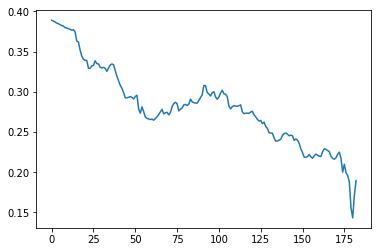

In [363]:
import matplotlib.pyplot as plt
plt.plot(cnn.val_loss)
plt.show()

For neural networks without hidden layer, we can compare the coefficients to the known true coefficients.

In [364]:
list(cnn.net.parameters())[0].detach().numpy()

array([[-0.0841725 ,  0.09875353,  0.07142214,  0.04690281, -0.11582379,
        -0.10721895, -0.00215474, -0.00468169,  0.06340275,  0.19547875]],
      dtype=float32)

In [365]:
coef_tau

array([-0.04881745,  0.13788995,  0.05775231,  0.07128759, -0.0433989 ,
       -0.09319255, -0.04073546, -0.01610772,  0.16573541,  0.122049  ])

The estimated coefficients don't seem to fit very well, usually. 

In [356]:
pred = cnn(torch.tensor(X).float()).detach().numpy()

In [357]:
pred.mean()

0.061663933

In [358]:
pred.flatten()[:10]

array([ 0.02150818, -0.5197296 ,  0.05525255, -0.14395401, -0.03769255,
        0.6021647 , -0.35010713,  0.58953685,  0.11604905,  0.12150869],
      dtype=float32)

In [359]:
tau[:10]

array([ 0.03013892, -0.0843743 ,  0.18227094, -0.26273309,  0.78784508,
        0.31387099, -0.1277751 ,  0.27967361,  0.08167208, -0.07879074])